# NBA DFS Runner Notebook

Combined backtesting and daily inference pipeline.

## Setup

In [1]:
import sys
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from src.walk_forward_backtest import WalkForwardBacktest
from src.data.loaders.historical_loader import HistoricalDataLoader
from src.data.storage.sqlite_storage import SQLiteStorage
from src.utils.feature_utils import FeatureBuilder
from src.data.collectors.tank01_client import Tank01Client
from dotenv import load_dotenv
import os

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

sns.set_style('whitegrid')

load_dotenv()
api_key = os.getenv("TANK01_API_KEY")

print('Setup complete')

Setup complete


## Mode Selection

In [2]:
MODE = 'backtest'

print(f'Running in {MODE.upper()} mode')

Running in BACKTEST mode


## Configuration

In [3]:
DB_PATH = repo_root / 'nba_dfs.db'
OUTPUT_DIR = repo_root / 'data' / 'outputs'

MODEL_TYPE = 'xgboost'
MODEL_PARAMS = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'random_state': 42
}

ROLLING_WINDOW_SIZES = [3, 10]
PER_PLAYER_MODELS = False
MIN_PLAYER_GAMES = 10
LOOKBACK_SEASONS = 2    
RECALIBRATE_DAYS = 7

if MODE == 'backtest':
    TRAIN_START = '20241001'
    TRAIN_END = '20250201'
    TEST_START = '20250201'
    TEST_END = '20250401'
else:
    today = datetime.now()
    TRAIN_START = (today - timedelta(days=90)).strftime('%Y%m%d')
    TRAIN_END = (today - timedelta(days=1)).strftime('%Y%m%d')
    TEST_START = today.strftime('%Y%m%d')
    TEST_END = TEST_START

print(f'Database: {DB_PATH}')
print(f'Output Directory: {OUTPUT_DIR}')
if MODE == 'backtest':
    print(f'Training Period: {TRAIN_START} to {TRAIN_END}')
    print(f'Testing Period: {TEST_START} to {TEST_END}')
else:
    print(f'Inference Date: {TEST_START}')
print(f'Model: {MODEL_TYPE}')
print(f'Window Sizes: {ROLLING_WINDOW_SIZES}')
print(f'Per-Player Models: {PER_PLAYER_MODELS}')
print(f'Min Player Games: {MIN_PLAYER_GAMES}')

Database: c:\Users\antho\OneDrive\Documents\Repositories\delapan-fantasy\nba_dfs.db
Output Directory: c:\Users\antho\OneDrive\Documents\Repositories\delapan-fantasy\data\outputs
Training Period: 20241001 to 20250201
Testing Period: 20250201 to 20250401
Model: xgboost
Window Sizes: [3, 10]
Per-Player Models: False
Min Player Games: 10


## Backtest Mode

In [4]:
if MODE == 'backtest':
    backtest = WalkForwardBacktest(
        db_path=str(DB_PATH),
        train_start=TRAIN_START,
        train_end=TRAIN_END,
        test_start=TEST_START,
        test_end=TEST_END,
        model_type=MODEL_TYPE,
        model_params=MODEL_PARAMS,
        rolling_window_sizes=ROLLING_WINDOW_SIZES,
        output_dir=str(OUTPUT_DIR),
        per_player_models=PER_PLAYER_MODELS,
        min_player_games=MIN_PLAYER_GAMES,
        recalibrate_days=RECALIBRATE_DAYS,
        num_seasons=LOOKBACK_SEASONS
    )
    
    results = backtest.run()
    
    print('Backtest complete')

2025-10-11 11:55:27,408 - src.data.storage.sqlite_storage - INFO - Initialized SQLiteStorage with database: c:\Users\antho\OneDrive\Documents\Repositories\delapan-fantasy\nba_dfs.db
2025-10-11 11:55:27,409 - src.walk_forward_backtest - INFO - Initialized WalkForwardBacktest
2025-10-11 11:55:27,409 - src.walk_forward_backtest - INFO - Training period: 20241001 to 20250201
2025-10-11 11:55:27,409 - src.walk_forward_backtest - INFO - Testing period: 20250201 to 20250401
2025-10-11 11:55:27,410 - src.walk_forward_backtest - INFO - Per-player models: False
2025-10-11 11:55:27,410 - src.walk_forward_backtest - INFO - Recalibrate every 7 days
2025-10-11 11:55:27,411 - src.walk_forward_backtest - INFO - Using new registry-based architecture with FeaturePipeline
2025-10-11 11:55:27,411 - src.walk_forward_backtest - INFO - ================================================================================
2025-10-11 11:55:27,411 - src.walk_forward_backtest - INFO - STARTING WALK-FORWARD BACKTEST
20


Backtesting 54 slates from 20250201 to 20250401



Backtesting slates:   0%|          | 0/54 [00:00<?, ?it/s]2025-10-11 11:55:27,424 - src.walk_forward_backtest - INFO - 
2025-10-11 11:55:27,424 - src.walk_forward_backtest - INFO - Processing slate 1/54: 20250201
2025-10-11 11:55:27,424 - src.data.loaders.historical_loader - INFO - Loading slate data for 20250201
2025-10-11 11:55:27,437 - src.data.loaders.historical_loader - INFO - Loaded slate data: 0 salaries, 9 games
2025-10-11 11:55:27,438 - src.walk_forward_backtest - WARNING - No salary data for 20250201, skipping
2025-10-11 11:55:27,439 - src.walk_forward_backtest - INFO - 
2025-10-11 11:55:27,439 - src.walk_forward_backtest - INFO - Processing slate 2/54: 20250202
2025-10-11 11:55:27,439 - src.data.loaders.historical_loader - INFO - Loading slate data for 20250202
2025-10-11 11:55:27,452 - src.data.loaders.historical_loader - INFO - Loaded slate data: 0 salaries, 5 games
2025-10-11 11:55:27,453 - src.walk_forward_backtest - WARNING - No salary data for 20250202, skipping
2025-1

Backtest complete


## Backtest Results Summary

In [5]:
if MODE == 'backtest' and 'error' not in results:
    print('='*80)
    print('BACKTEST RESULTS SUMMARY')
    print('='*80)
    print(f"\nNumber of Slates: {results['num_slates']}")
    print(f"Date Range: {results['date_range']}")
    print(f"\nTotal Players Evaluated: {results['total_players_evaluated']:.0f}")
    print(f"Average Players per Slate: {results['avg_players_per_slate']:.1f}")
    print(f"\nMean MAPE: {results['mean_mape']:.2f}%")
    print(f"Median MAPE: {results['median_mape']:.2f}%")
    print(f"Std MAPE: {results['std_mape']:.2f}%")
    print(f"\nMean RMSE: {results['mean_rmse']:.2f}")
    print(f"Std RMSE: {results['std_rmse']:.2f}")
    print(f"\nMean Correlation: {results['mean_correlation']:.3f}")
    print(f"Std Correlation: {results['std_correlation']:.3f}")
    print('='*80)
elif MODE == 'backtest':
    print(f"ERROR: {results.get('error', 'Unknown error')}")

BACKTEST RESULTS SUMMARY

Number of Slates: 50
Date Range: 20250205 to 20250331

Total Players Evaluated: 22669
Average Players per Slate: 453.4

Mean MAPE: 78.59%
Median MAPE: 74.50%
Std MAPE: 17.54%

Mean RMSE: 11.17
Std RMSE: 1.12

Mean Correlation: 0.668
Std Correlation: 0.074


## Backtest Visualizations

2025-10-11 11:59:02,095 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-11 11:59:02,096 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-11 11:59:02,101 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-11 11:59:02,103 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-11 11:59:02,

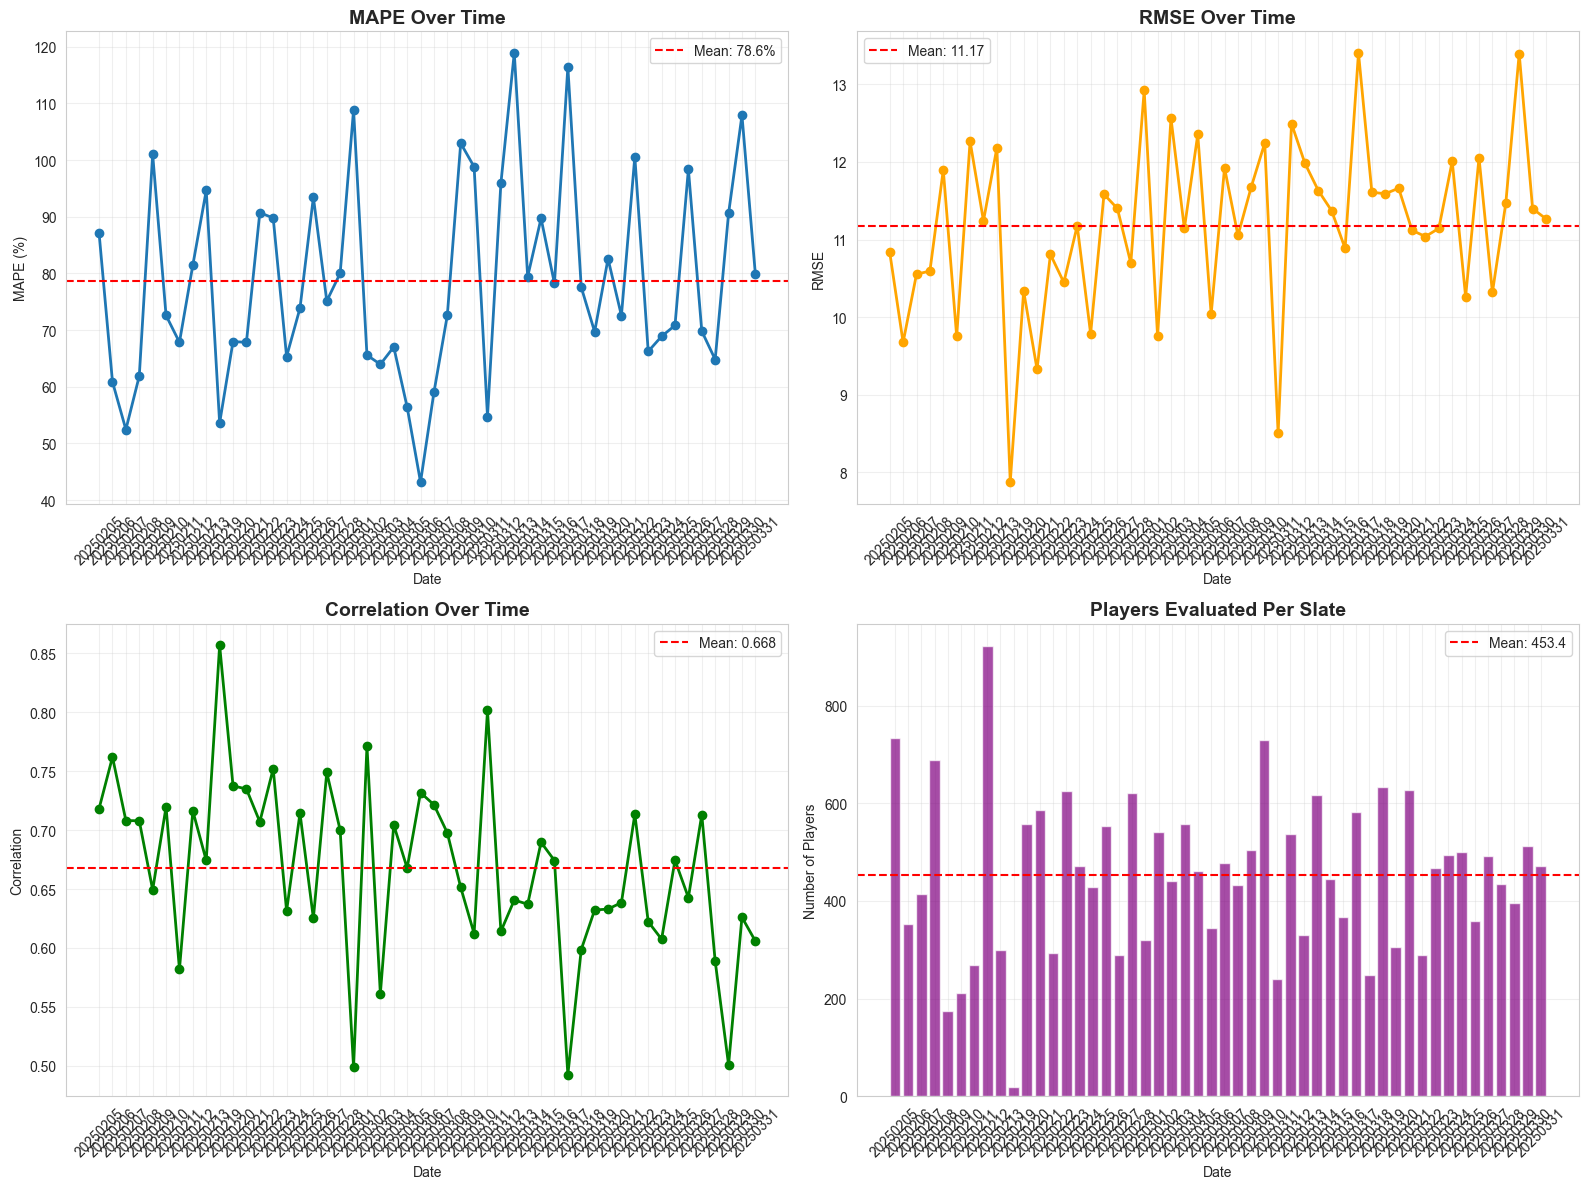

In [6]:
if MODE == 'backtest' and 'error' not in results and 'daily_results' in results:
    daily_df = results['daily_results']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    axes[0, 0].plot(daily_df['date'], daily_df['mape'], marker='o', linewidth=2)
    axes[0, 0].axhline(y=daily_df['mape'].mean(), color='r', linestyle='--', label=f'Mean: {daily_df["mape"].mean():.1f}%')
    axes[0, 0].set_title('MAPE Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAPE (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    axes[0, 1].plot(daily_df['date'], daily_df['rmse'], marker='o', linewidth=2, color='orange')
    axes[0, 1].axhline(y=daily_df['rmse'].mean(), color='r', linestyle='--', label=f'Mean: {daily_df["rmse"].mean():.2f}')
    axes[0, 1].set_title('RMSE Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)   
    
    axes[1, 0].plot(daily_df['date'], daily_df['correlation'], marker='o', linewidth=2, color='green')
    axes[1, 0].axhline(y=daily_df['correlation'].mean(), color='r', linestyle='--', label=f'Mean: {daily_df["correlation"].mean():.3f}')
    axes[1, 0].set_title('Correlation Over Time', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Correlation')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    axes[1, 1].bar(daily_df['date'], daily_df['num_players'], color='purple', alpha=0.7)
    axes[1, 1].axhline(y=daily_df['num_players'].mean(), color='r', linestyle='--', label=f'Mean: {daily_df["num_players"].mean():.1f}')
    axes[1, 1].set_title('Players Evaluated Per Slate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Number of Players')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## Daily Inference Mode

In [7]:
if MODE == 'inference':
    print(f'Running inference for {TEST_START}')
    
    storage = SQLiteStorage(str(DB_PATH))
    loader = HistoricalDataLoader(storage)
    feature_builder = FeatureBuilder()
    client = Tank01Client(api_key)
    
    print('\nFetching today\'s slate data...')
    
    salaries_resp = client.get_dfs_salaries(date=TEST_START, lineup_type='DraftKings')
    schedule_resp = client.get_schedule(date=TEST_START)
    
    if salaries_resp['statusCode'] != 200:
        print(f"ERROR fetching salaries: {salaries_resp}")
    else:
        salaries_df = pd.DataFrame(salaries_resp['body'])
        print(f"Found {len(salaries_df)} players on slate")
        
        if schedule_resp['statusCode'] == 200:
            schedule_df = pd.DataFrame(schedule_resp['body'])
            print(f"Found {len(schedule_df)} games")
        else:
            schedule_df = pd.DataFrame()
            print('No schedule data available')
        
        slate_data = {
            'dfs_salaries': salaries_df,
            'schedule': schedule_df,
            'date': TEST_START
        }
        
        print(f'\nLoading historical data from current and previous seasons...')
        training_data = loader.load_historical_player_logs(
            end_date=TEST_START
        )
        print(f"Loaded {len(training_data)} historical games")
        
        projections_list = []
        
        print(f'\nGenerating projections for {len(salaries_df)} players...')
        
        for idx, player_row in salaries_df.iterrows():
            player_id = player_row.get('playerID')
            player_name = player_row.get('longName') or player_row.get('playerName', '')
            
            player_training_data = training_data[training_data['playerID'] == player_id].copy()
            
            if len(player_training_data) < MIN_PLAYER_GAMES:
                continue
            
            try:
                X_train, y_train = feature_builder.build_training_features(
                    player_training_data,
                    window_sizes=ROLLING_WINDOW_SIZES
                )
                
                if X_train.empty or y_train.empty or len(X_train) < 3:
                    continue
                
                if MODEL_TYPE == 'xgboost':
                    import xgboost as xgb
                    model = xgb.XGBRegressor(**MODEL_PARAMS)
                    model.fit(X_train, y_train, verbose=False)
                else:
                    from sklearn.ensemble import RandomForestRegressor
                    model = RandomForestRegressor(
                        n_estimators=MODEL_PARAMS.get('n_estimators', 200),
                        max_depth=MODEL_PARAMS.get('max_depth', 6),
                        random_state=MODEL_PARAMS.get('random_state', 42),
                        n_jobs=-1
                    )
                    model.fit(X_train, y_train)
                
                slate_data_single = {
                    'dfs_salaries': salaries_df.iloc[[idx]],
                    'date': TEST_START
                }
                
                slate_features = feature_builder.build_slate_features(
                    slate_data_single,
                    player_training_data,
                    window_sizes=ROLLING_WINDOW_SIZES
                )
                
                if slate_features.empty:
                    continue
                
                metadata_cols = ['playerID', 'playerName', 'team', 'pos', 'salary']
                feature_cols = [col for col in slate_features.columns if col not in metadata_cols]
                
                X = slate_features[feature_cols].fillna(0)
                prediction = model.predict(X)[0]
                
                projection = {
                    'playerID': player_id,
                    'playerName': player_name,
                    'team': player_row.get('team', ''),
                    'pos': player_row.get('pos', ''),
                    'salary': player_row.get('salary', 0),
                    'projected_fpts': prediction,
                    'value': prediction / (player_row.get('salary', 1) / 1000)
                }
                
                projections_list.append(projection)
                
            except Exception as e:
                logger.warning(f"Error generating projection for {player_name}: {str(e)}")
                continue
        
        projections_df = pd.DataFrame(projections_list)
        projections_df = projections_df.sort_values('projected_fpts', ascending=False)
        
        print(f'\nGenerated {len(projections_df)} projections')
        
        OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        output_file = OUTPUT_DIR / f'projections_{TEST_START}.csv'
        projections_df.to_csv(output_file, index=False)
        print(f'\nProjections saved to: {output_file}')
        
        print('\nTop 20 Projections:')
        display(projections_df.head(20))
        
        print('\nTop 20 By Value:')
        display(projections_df.sort_values('value', ascending=False).head(20))

## Export Results

In [8]:
if MODE == 'backtest' and 'error' not in results and 'daily_results' in results:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    daily_df = results['daily_results']
    csv_path = OUTPUT_DIR / f'backtest_results_{TEST_START}_to_{TEST_END}.csv'
    daily_df.to_csv(csv_path, index=False)
    print(f'Results exported to: {csv_path}')
    
    summary_path = OUTPUT_DIR / f'summary_{TEST_START}_to_{TEST_END}.txt'
    with open(summary_path, 'w') as f:
        f.write('='*80 + '\n')
        f.write('BACKTEST RESULTS SUMMARY\n')
        f.write('='*80 + '\n\n')
        f.write(f"Date Range: {results['date_range']}\n")
        f.write(f"Number of Slates: {results['num_slates']}\n")
        f.write(f"Total Players Evaluated: {results['total_players_evaluated']:.0f}\n")
        f.write(f"Average Players per Slate: {results['avg_players_per_slate']:.1f}\n\n")
        f.write(f"Mean MAPE: {results['mean_mape']:.2f}%\n")
        f.write(f"Median MAPE: {results['median_mape']:.2f}%\n")
        f.write(f"Std MAPE: {results['std_mape']:.2f}%\n\n")
        f.write(f"Mean RMSE: {results['mean_rmse']:.2f}\n")
        f.write(f"Std RMSE: {results['std_rmse']:.2f}\n\n")
        f.write(f"Mean Correlation: {results['mean_correlation']:.3f}\n")
        f.write(f"Std Correlation: {results['std_correlation']:.3f}\n")
    
    print(f'Summary exported to: {summary_path}')

Results exported to: c:\Users\antho\OneDrive\Documents\Repositories\delapan-fantasy\data\outputs\backtest_results_20250201_to_20250401.csv
Summary exported to: c:\Users\antho\OneDrive\Documents\Repositories\delapan-fantasy\data\outputs\summary_20250201_to_20250401.txt
